## Model 3 -- SVM

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
!pip install scikeras

Use model 2 to label record as "fair" or "unfair

In [ ]:
! git clone "https://github.com/Daniel-Tran3/CSE_151A_Project.git"

Cloning into 'CSE_151A_Project'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 510 (delta 23), reused 3 (delta 3), pack-reused 481
Receiving objects: 100% (510/510), 28.27 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Updating files: 100% (104/104), done.


In [ ]:
data = pd.read_csv('CSE_151A_Project/final_cleaned.csv')
data.head()

,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,1.0,0.0,0.011281,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.004302,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.022753,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.013862,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.013002,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

from keras.models import load_model

ANNmodel = load_model('./CSE_151A_Project/ANN_model.keras')

unprocessed_data = pd.read_csv('CSE_151A_Project/apartments_for_rent_classified_10K_utf.csv')

# ANNmodel.summary()

X = data.drop(['price', 'time'], axis=1)
fairness_data = data.copy()
fairness_data['predicted_price'] = ANNmodel.predict(X)
fairness_data['unscaled_price'] = unprocessed_data['price']
fairness_data.head()

# if the actual price is more than 30% more than the predicted price, the value in the fairness column is 'unfair', otherwise it is 'fair'
fairness_data['fairness'] = np.where(fairness_data['unscaled_price'] > 1.3*fairness_data['predicted_price'], 'unfair', 'fair')
fairness_data['fairness'].value_counts()

fairness_data.head()

# save fairness_data to a csv for future use
# fairness_data.to_csv('fairness_data.csv', index=False)

313/313 [==============================] - 1s 3ms/step


,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf,predicted_price,unscaled_price,fairness
0,1.0,0.0,0.011281,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,1773.028076,790,fair
1,1.0,1.0,0.004302,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,564.618286,425,fair
2,1.0,0.0,0.022753,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,1289.576904,1390,fair
3,1.0,0.0,0.013862,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,1565.849365,925,fair
4,1.0,0.0,0.013002,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,1291.815063,880,fair


In [21]:
from sklearn.model_selection import train_test_split

# encode fiarness to 0 and 1
fairness_mapping = {'fair': 0, 'unfair': 1}
fairness_data['fairness_encoded'] = fairness_data['fairness'].map(fairness_mapping)

X = fairness_data.drop(columns=['price', 'time', 'predicted_price', 'fairness'])  # Features
y = fairness_data['fairness_encoded']  # Target variable

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
# sns.pairplot(data, hue='price_class', palette='colorblind')

From the result of pairplot. Let's pick ____ as our features.

That's not an ideal approach since we have 1600+ features. Plotting pairplot takes huge time.

Let's use RFE to select features: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html#:~:text=Recursive%20feature%20elimination%20(RFE)%20is,number%20of%20features%20is%20reached.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel="linear")

#num_features_to_select = 100  # Adjust as needed

#rfe = RFE(estimator, n_features_to_select=num_features_to_select)
#rfe.fit(X_train, y_train)

#selected_features = X_train.columns[rfe.support_]
#X_train_selected = X_train[selected_features]
#X_test_selected = X_test[selected_features]

X_train_selected = X_train
X_test_selected = X_test
X_val_selected = X_val

Let's train linear and RBF SVMs and evaluate them.

Leaner SVM

In [ ]:
svm_linear_model = SVC(kernel='linear')
svm_linear_model.fit(X_train_selected, y_train)

SVC(kernel='linear')

In [ ]:
# evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

yhat_train_linear = svm_linear_model.predict(X_train_selected)
yhat_test_linear = svm_linear_model.predict(X_test_selected)
yhat_val_linear = svm_linear_model.predict(X_val_selected)

print("Train results")
accuracy = accuracy_score(y_train, yhat_train_linear)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_train, yhat_train_linear))

conf_matrix = confusion_matrix(y_train, yhat_train_linear)
print("\nConfusion Matrix:")
print(conf_matrix)

print("Test results")
accuracy = accuracy_score(y_test, yhat_test_linear)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, yhat_test_linear))

conf_matrix = confusion_matrix(y_test, yhat_test_linear)
print("\nConfusion Matrix:")
print(conf_matrix)

print("Validation results")
accuracy = accuracy_score(y_val, yhat_val_linear)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_val, yhat_val_linear))

conf_matrix = confusion_matrix(y_val, yhat_val_linear)
print("\nConfusion Matrix:")
print(conf_matrix)

Train results
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4812
           1       1.00      1.00      1.00      1586

    accuracy                           1.00      6398
   macro avg       1.00      1.00      1.00      6398
weighted avg       1.00      1.00      1.00      6398


Confusion Matrix:
[[4812    0]
 [   0 1586]]
Test results
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1522
           1       1.00      1.00      1.00       478

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
[[1522    0]
 [   0  478]]
Validation results
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import cross_validate
from scikeras.wrappers import KerasClassifier


# Implementing early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, restore_best_weights=True)

# Use RepeatedKFold with n_splits=10, n_repeats=1 to implement 10-fold cross validation
# Used batch_size of 100 so that time wouldn't be too long
# estimator = KerasClassifier(model=svm_linear_model, epochs=100, batch_size=100, verbose=0)
kfold=RepeatedKFold(n_splits=10, n_repeats=1)

# Perform cross validation with metrics of accuracy, precision, and recall
scoring = ['accuracy', 'precision', 'recall']
scores = cross_validate(svm_linear_model, X_train, y_train, cv=kfold, n_jobs=1, return_train_score=True, scoring=scoring, verbose=0)

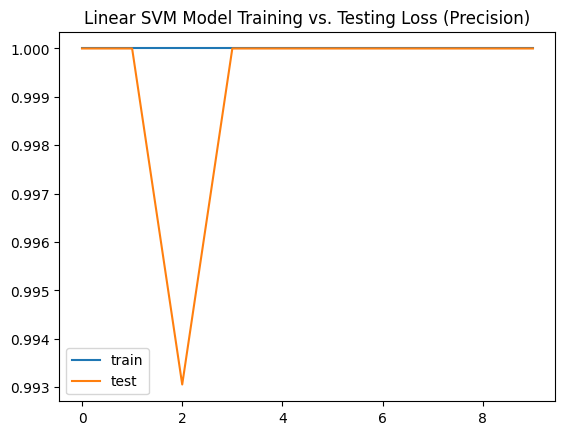

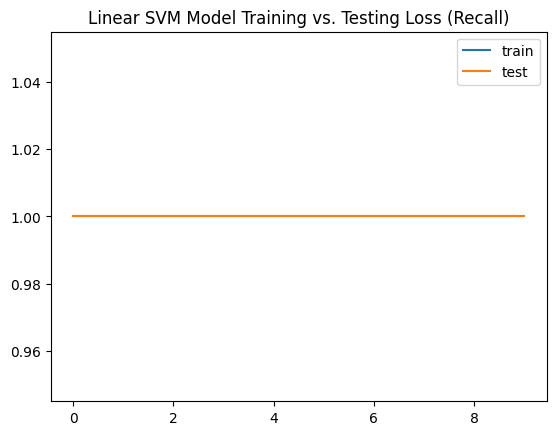

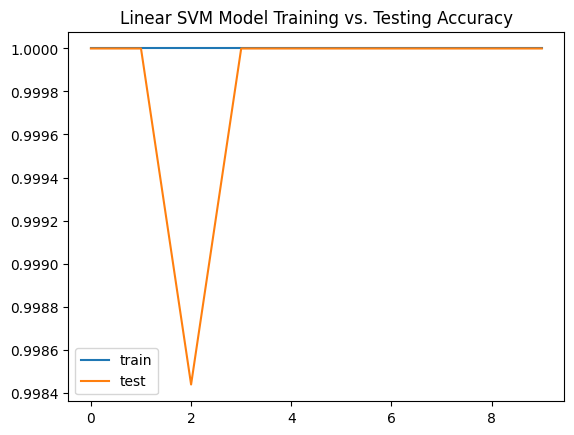

In [ ]:
# graphing loss through iterations
plt.plot(scores['train_precision'], label='train')
plt.plot(scores['test_precision'], label='test')
plt.title('Linear SVM Model Training vs. Testing Loss (Precision)')
plt.legend()
plt.show()

plt.plot(scores['train_recall'], label='train')
plt.plot(scores['test_recall'], label='test')
plt.title('Linear SVM Model Training vs. Testing Loss (Recall)')
plt.legend()
plt.show()

plt.plot(scores['train_accuracy'], label='train')
plt.plot(scores['test_accuracy'], label='test')
plt.title('Linear SVM Model Training vs. Testing Accuracy')
plt.legend()
plt.show()


Linear SVM looks awesome! No need to tunr hp.

RBF SVM

In [ ]:
svm_rbf_model = SVC(kernel='rbf')
svm_rbf_model.fit(X_train_selected, y_train)

SVC()

In [ ]:
# evaluation

yhat_train_rbf = svm_rbf_model.predict(X_train_selected)
yhat_test_rbf = svm_rbf_model.predict(X_test_selected)
yhat_val_rbf = svm_rbf_model.predict(X_val_selected)

print("Train results")
accuracy_rbf = accuracy_score(y_train, yhat_train_rbf)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_train, yhat_train_rbf))

conf_matrix_rbf = confusion_matrix(y_train, yhat_train_rbf)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf)

print("Test results")
accuracy_rbf = accuracy_score(y_test, yhat_test_rbf)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_test, yhat_test_rbf))

conf_matrix_rbf = confusion_matrix(y_test, yhat_test_rbf)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf)

print("Validation results")
accuracy_rbf = accuracy_score(y_val, yhat_val_rbf)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_val, yhat_val_rbf))

conf_matrix_rbf = confusion_matrix(y_val, yhat_val_rbf)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf)

Train results
Accuracy (SVC with RBF kernel): 0.8013441700531416

Classification Report (SVC with RBF kernel):
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4812
           1       0.74      0.31      0.44      1586

    accuracy                           0.80      6398
   macro avg       0.77      0.64      0.66      6398
weighted avg       0.79      0.80      0.77      6398


Confusion Matrix (SVC with RBF kernel):
[[4635  177]
 [1094  492]]
Test results
Accuracy (SVC with RBF kernel): 0.799

Classification Report (SVC with RBF kernel):
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1522
           1       0.70      0.28      0.40       478

    accuracy                           0.80      2000
   macro avg       0.75      0.62      0.64      2000
weighted avg       0.78      0.80      0.76      2000


Confusion Matrix (SVC with RBF kernel):
[[1464   58]
 [ 344  134]]
Va

In [ ]:
# Implementing early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, restore_best_weights=True)

# Use RepeatedKFold with n_splits=10, n_repeats=1 to implement 10-fold cross validation
# Used batch_size of 100 so that time wouldn't be too long
# estimator2 = KerasClassifier(model=svm_rbf_model, epochs=100, batch_size=100, verbose=0)
kfold=RepeatedKFold(n_splits=10, n_repeats=1)

# Perform cross validation with metrics of accuracy, precision, and recall
scoring = ['accuracy', 'precision', 'recall']
scores2 = cross_validate(svm_rbf_model, X_train, y_train, cv=kfold, n_jobs=1, return_train_score=True, scoring=scoring, verbose=0)

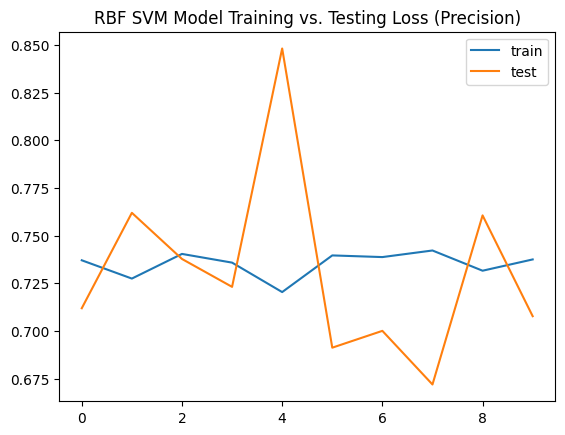

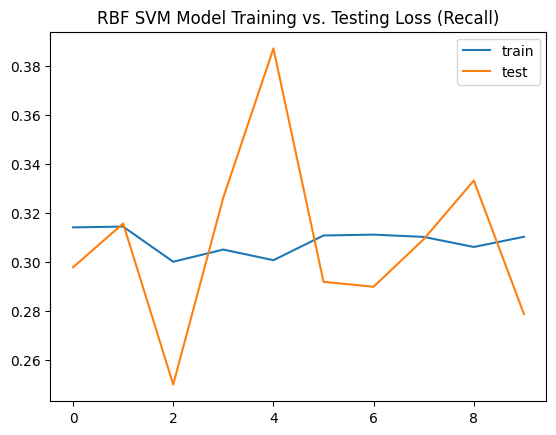

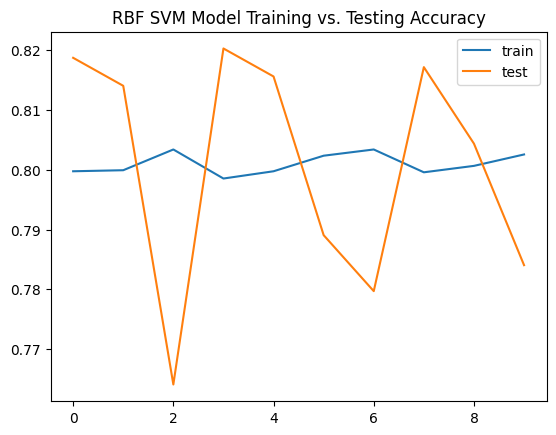

In [ ]:
# graphing loss through iterations
plt.plot(scores2['train_precision'], label='train')
plt.plot(scores2['test_precision'], label='test')
plt.title('RBF SVM Model Training vs. Testing Loss (Precision)')
plt.legend()
plt.show()

plt.plot(scores2['train_recall'], label='train')
plt.plot(scores2['test_recall'], label='test')
plt.title('RBF SVM Model Training vs. Testing Loss (Recall)')
plt.legend()
plt.show()

plt.plot(scores2['train_accuracy'], label='train')
plt.plot(scores2['test_accuracy'], label='test')
plt.title('RBF SVM Model Training vs. Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
# Performance of RBF is not as good as linear
# Let's tune RBF hp somehow
from sklearn.model_selection import GridSearchCV
import json

param_grid = {
    'C': [0.1, 1, 10, 100],  #controls the trade-off between maximizing the margin and minimizing the classification error.
    'gamma': [0.001, 0.01, 0.1, 1]  # defines how far the influence of a single training example reaches
}

svm_rbf_tuning = SVC(kernel='rbf')

grid_search = GridSearchCV(svm_rbf_tuning, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)


best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)

# Save hp
best_hyperparameters = {
    'C': best_params['C'],
    'gamma': best_params['gamma']
}

# save into json file
with open('SVM_RBF_best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

print("Best hyperparameters saved to 'best_hyperparameters.json':", best_hyperparameters)

Best hyperparameters: {'C': 100, 'gamma': 0.001}
Best cross-validation accuracy: 0.9867145963643471
Test set accuracy: 0.989
Best hyperparameters saved to 'best_hyperparameters.json': {'C': 100, 'gamma': 0.001}


In [ ]:
# Let's fit in best hp and train again

# open file and read best parameter
with open('CSE_151A_Project/SVM_RBF_best_hyperparameters.json', 'r') as f:
    best_hyperparameters = json.load(f)

svm_rbf_best = SVC(kernel='rbf', C=best_hyperparameters['C'], gamma=best_hyperparameters['gamma'])

# Train the SVM model on your data
svm_rbf_best.fit(X_train_selected, y_train)

yhat_train_rbf_best = svm_rbf_best.predict(X_train_selected)
yhat_test_rbf_best = svm_rbf_best.predict(X_test_selected)
yhat_val_rbf_best = svm_rbf_best.predict(X_val_selected)

print("Train results")
accuracy_rbf_best = accuracy_score(y_train, yhat_train_rbf_best)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_train, yhat_train_rbf_best))

conf_matrix_rbf_best = confusion_matrix(y_train, yhat_train_rbf_best)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf_best)

print("Test results")
accuracy_rbf_best = accuracy_score(y_test, yhat_test_rbf_best)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf_best)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_test, yhat_test_rbf_best))

conf_matrix_rbf_best = confusion_matrix(y_test, yhat_test_rbf_best)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf_best)

print("Validation results")
accuracy_rbf_best = accuracy_score(y_val, yhat_val_rbf_best)
print("Accuracy (SVC with RBF kernel):", accuracy_rbf_best)

print("\nClassification Report (SVC with RBF kernel):")
print(classification_report(y_val, yhat_val_rbf_best))

conf_matrix_rbf_best = confusion_matrix(y_val, yhat_val_rbf_best)
print("\nConfusion Matrix (SVC with RBF kernel):")
print(conf_matrix_rbf_best)

Train results
Accuracy (SVC with RBF kernel): 0.78875

Classification Report (SVC with RBF kernel):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4812
           1       1.00      1.00      1.00      1586

    accuracy                           1.00      6398
   macro avg       1.00      1.00      1.00      6398
weighted avg       1.00      1.00      1.00      6398


Confusion Matrix (SVC with RBF kernel):
[[4811    1]
 [   2 1584]]
Test results
Accuracy (SVC with RBF kernel): 0.989

Classification Report (SVC with RBF kernel):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1522
           1       0.97      0.98      0.98       478

    accuracy                           0.99      2000
   macro avg       0.98      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000


Confusion Matrix (SVC with RBF kernel):
[[1509   13]
 [   9  469]]
Validation re

In [24]:
# Implementing early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, restore_best_weights=True)

# Use RepeatedKFold with n_splits=10, n_repeats=1 to implement 10-fold cross validation
# Used batch_size of 100 so that time wouldn't be too long
# estimator2 = KerasClassifier(model=svm_rbf_model, epochs=100, batch_size=100, verbose=0)
kfold=RepeatedKFold(n_splits=10, n_repeats=1)

# Perform cross validation with metrics of accuracy, precision, and recall
scoring = ['accuracy', 'precision', 'recall']
scores3 = cross_validate(svm_rbf_best, X_train, y_train, cv=kfold, n_jobs=1, return_train_score=True, scoring=scoring, verbose=0)

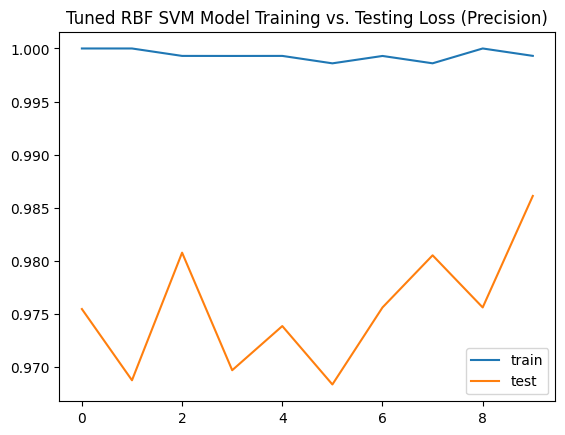

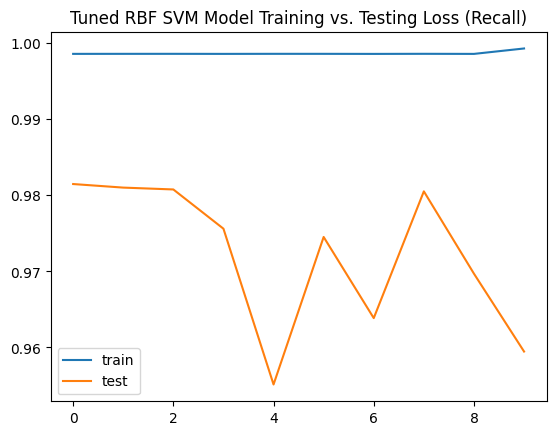

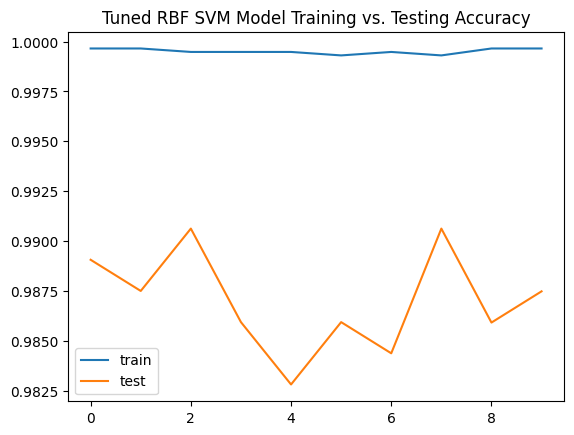

In [25]:
# graphing loss through iterations
plt.plot(scores3['train_precision'], label='train')
plt.plot(scores3['test_precision'], label='test')
plt.title('Tuned RBF SVM Model Training vs. Testing Loss (Precision)')
plt.legend()
plt.show()

plt.plot(scores3['train_recall'], label='train')
plt.plot(scores3['test_recall'], label='test')
plt.title('Tuned RBF SVM Model Training vs. Testing Loss (Recall)')
plt.legend()
plt.show()

plt.plot(scores3['train_accuracy'], label='train')
plt.plot(scores3['test_accuracy'], label='test')
plt.title('Tuned RBF SVM Model Training vs. Testing Accuracy')
plt.legend()
plt.show()